# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Random Forest with StatQuest

## References

**::GMG::** These ones:

 - [StatQuest](https://www.youtube.com/watch?v=6EXPYzbfLCE) Youtube Channel Vídeo: Random Forest in R
 - [StatQuest](https://statquest.org/2018/02/26/statquest-random-forests-in-r/) Blog: Random Forest in R (includes video and code)

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [2]:
#::GMG:: The one I didn't know ...
# cowplot: Streamlined Plot Theme and Plot Annotations for 'ggplot2'
# https://cran.r-project.org/web/packages/cowplot/index.html
# https://cran.r-project.org/web/packages/cowplot/cowplot.pdf
# https://cran.r-project.org/web/packages/cowplot/vignettes/introduction.html
using('ggplot2', 'cowplot', 'randomForest')

Loading required package: ggplot2
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



## Dataset

In [3]:
## NOTE: The data used in this demo comes from the UCI machine learning
## repository.
## http://archive.ics.uci.edu/ml/index.php
## Specifically, this is the heart disease data set.
## http://archive.ics.uci.edu/ml/datasets/Heart+Disease
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data <- read.csv(url, header=FALSE)

In [4]:
#####################################
##
## Reformat the data so that it is
## 1) Easy to use (add nice column names)
## 2) Interpreted correctly by randomForest..
##
#####################################
head(data) # you see data, but no column names

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [5]:
colnames(data) <- c(
  "age",
  "sex",# 0 = female, 1 = male
  "cp", # chest pain
          # 1 = typical angina,
          # 2 = atypical angina,
          # 3 = non-anginal pain,
          # 4 = asymptomatic
  "trestbps", # resting blood pressure (in mm Hg)
  "chol", # serum cholestoral in mg/dl
  "fbs",  # fasting blood sugar greater than 120 mg/dl, 1 = TRUE, 0 = FALSE
  "restecg", # resting electrocardiographic results
          # 1 = normal
          # 2 = having ST-T wave abnormality
          # 3 = showing probable or definite left ventricular hypertrophy
  "thalach", # maximum heart rate achieved
  "exang",   # exercise induced angina, 1 = yes, 0 = no
  "oldpeak", # ST depression induced by exercise relative to rest
  "slope", # the slope of the peak exercise ST segment
          # 1 = upsloping
          # 2 = flat
          # 3 = downsloping
  "ca", # number of major vessels (0-3) colored by fluoroscopy
  "thal", # this is short of thalium heart scan
          # 3 = normal (no cold spots)
          # 6 = fixed defect (cold spots during rest and exercise)
          # 7 = reversible defect (when cold spots only appear during exercise)
  "hd" # (the predicted attribute) - diagnosis of heart disease
          # 0 if less than or equal to 50% diameter narrowing
          # 1 if greater than 50% diameter narrowing
  )
 
head(data) # now we have data and column names

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


## Pre-processing

In [6]:
str(data) # this shows that we need to tell R which columns contain factors
          # it also shows us that there are some missing values. There are "?"s
          # in the dataset.
 

'data.frame':	303 obs. of  14 variables:
 $ age     : num  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : num  1 1 1 1 0 1 0 0 1 1 ...
 $ cp      : num  1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: num  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : num  233 286 229 250 204 236 268 354 254 203 ...
 $ fbs     : num  1 0 0 0 0 0 0 0 0 1 ...
 $ restecg : num  2 2 2 0 2 0 2 0 2 2 ...
 $ thalach : num  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : num  0 1 1 0 0 0 0 1 0 1 ...
 $ oldpeak : num  2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ slope   : num  3 2 2 3 1 1 3 1 2 3 ...
 $ ca      : Factor w/ 5 levels "?","0.0","1.0",..: 2 5 4 2 2 2 4 2 3 2 ...
 $ thal    : Factor w/ 4 levels "?","3.0","6.0",..: 3 2 4 2 2 2 2 2 4 4 ...
 $ hd      : int  0 2 1 0 0 0 3 0 2 1 ...


In [7]:
## First, replace "?"s with NAs.
data[data == "?"] <- NA 

In [8]:
## Now add factors for variables that are factors and clean up the factors
## that had missing data...
data[data$sex == 0,]$sex <- "F"
data[data$sex == 1,]$sex <- "M"
data$sex <- as.factor(data$sex) 

In [9]:
data$cp <- as.factor(data$cp)
data$fbs <- as.factor(data$fbs)
data$restecg <- as.factor(data$restecg)
data$exang <- as.factor(data$exang)
data$slope <- as.factor(data$slope) 

In [10]:
data$ca <- as.integer(data$ca) # since this column had "?"s in it (which
                               # we have since converted to NAs) R thinks that
                               # the levels for the factor are strings, but
                               # we know they are integers, so we'll first
                               # convert the strings to integiers...
data$ca <- as.factor(data$ca)  # ...then convert the integers to factor levels

In [11]:
data$thal <- as.integer(data$thal) # "thal" also had "?"s in it.
data$thal <- as.factor(data$thal)
 

In [12]:
## This next line replaces 0 and 1 with "Healthy" and "Unhealthy"
data$hd <- ifelse(test=data$hd == 0, yes="Healthy", no="Unhealthy")
data$hd <- as.factor(data$hd) # Now convert to a factor

In [13]:
str(data) ## this shows that the correct columns are factors and we've replaced
## "?"s with NAs because "?" no longer appears in the list of factors
## for "ca" and "thal"

'data.frame':	303 obs. of  14 variables:
 $ age     : num  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : Factor w/ 2 levels "F","M": 2 2 2 2 1 2 1 1 2 2 ...
 $ cp      : Factor w/ 4 levels "1","2","3","4": 1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: num  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : num  233 286 229 250 204 236 268 354 254 203 ...
 $ fbs     : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 2 ...
 $ restecg : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 1 3 1 3 3 ...
 $ thalach : num  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 2 ...
 $ oldpeak : num  2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ slope   : Factor w/ 3 levels "1","2","3": 3 2 2 3 1 1 3 1 2 3 ...
 $ ca      : Factor w/ 4 levels "2","3","4","5": 1 4 3 1 1 1 3 1 2 1 ...
 $ thal    : Factor w/ 3 levels "2","3","4": 2 1 3 1 1 1 1 1 3 3 ...
 $ hd      : Factor w/ 2 levels "Healthy","Unhealthy": 1 2 2 1 1 1 2 1 2 2 ...


## Train/Test split?

> NOTE: For most machine learning methods, you need to divide the data
 manually into a "training" set and a "test" set. This allows you to train
 the method using the training data, and then test it on data it was not
 originally trained on.
>
> In contrast, Random Forests split the data into "training" and "test" sets
 for you. This is because Random Forests use bootstrapped
 data, and thus, not every sample is used to build every tree. The
 "training" dataset is the bootstrapped data and the "test" dataset is
 the remaining samples. The remaining samples are called
 the "Out-Of-Bag" (OOB) data.

## Imputation

In [14]:
#####################################
##
## Now we are ready to build a random forest.
##
#####################################
set.seed(42)

In [15]:
## impute any missing values in the training set using proximities
data.imputed <- rfImpute(hd ~ ., data = data, iter=6)
## NOTE: iter = the number of iterations to run. Breiman says 4 to 6 iterations
## is usually good enough. With this dataset, when we set iter=6, OOB-error
## bounces around between 17% and 18%. When we set iter=20,
# set.seed(42)
# data.imputed <- rfImpute(hd ~ ., data = data, iter=20)
## we get values a little better and a little worse, so doing more
## iterations doesn't improve the situation.
##
## NOTE: If you really want to micromanage how rfImpute(),
## you can change the number of trees it makes (the default is 300) and the
## number of variables that it will consider at each step.

ntree      OOB      1      2
  300:  17.49% 12.80% 23.02%
ntree      OOB      1      2
  300:  16.83% 14.02% 20.14%
ntree      OOB      1      2
  300:  17.82% 13.41% 23.02%
ntree      OOB      1      2
  300:  17.49% 14.02% 21.58%
ntree      OOB      1      2
  300:  17.16% 12.80% 22.30%
ntree      OOB      1      2
  300:  18.15% 14.63% 22.30%


## Model

In [16]:
## Now we are ready to build a random forest.
 
## NOTE: If the thing we're trying to predict (in this case it is
## whether or not someone has heart disease) is a continuous number
## (i.e. "weight" or "height"), then by default, randomForest() will set
## "mtry", the number of variables to consider at each step,
## to the total number of variables divided by 3 (rounded down), or to 1
## (if the division results in a value less than 1).
## If the thing we're trying to predict is a "factor" (i.e. either "yes/no"
## or "ranked"), then randomForest() will set mtry to
## the square root of the number of variables (rounded down to the next
## integer value).
 
## In this example, "hd", the thing we are trying to predict, is a factor and
## there are 13 variables. So by default, randomForest() will set
## mtry = sqrt(13) = 3.6 rounded down = 3
## Also, by default random forest generates 500 trees (NOTE: rfImpute() only
## generates 300 tress by default)
model <- randomForest(hd ~ ., data=data.imputed, proximity=TRUE)

In [17]:
## RandomForest returns all kinds of things
model # gives us an overview of the call, along with...
      # 1) The OOB error rate for the forest with ntree trees.
      #    In this case ntree=500 by default
      # 2) The confusion matrix for the forest with ntree trees.
      #    The confusion matrix is laid out like this:
#
#                Healthy                      Unhealthy
#          --------------------------------------------------------------
# Healthy  | Number of healthy people   | Number of healthy people      |
#          | correctly called "healthy" | incorectly called "unhealthy" |
#          | by the forest.             | by the forest                 |
#          --------------------------------------------------------------
# Unhealthy| Number of unhealthy people | Number of unhealthy peole     |
#          | incorrectly called         | correctly called "unhealthy"  |
#          | "healthy" by the forest    | by the forest                 |
#          --------------------------------------------------------------


Call:
 randomForest(formula = hd ~ ., data = data.imputed, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 16.83%
Confusion matrix:
          Healthy Unhealthy class.error
Healthy       142        22   0.1341463
Unhealthy      29       110   0.2086331

## Evaluation

In [18]:
## Now check to see if the random forest is actually big enough...
## Up to a point, the more trees in the forest, the better. You can tell when
## you've made enough when the OOB no longer improves.
oob.error.data <- data.frame(
      Trees = rep(1:nrow(model$err.rate), times=3),
      Type = rep(c("OOB", "Healthy", "Unhealthy"), each=nrow(model$err.rate)),
      Error = c(model$err.rate[,"OOB"], model$err.rate[,"Healthy"], model$err.rate[,"Unhealthy"])
)

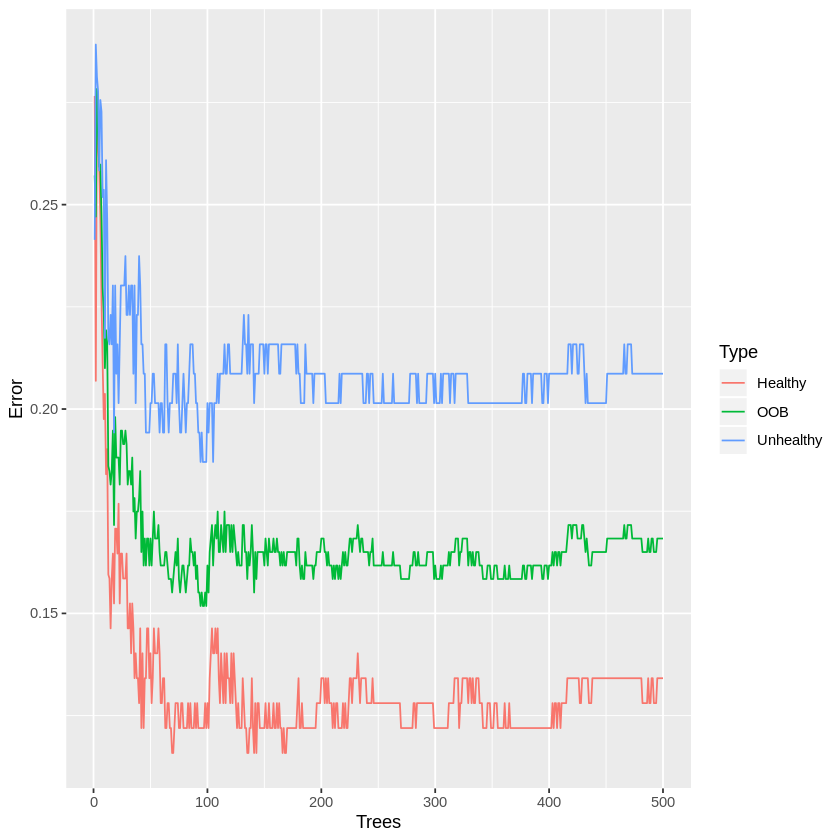

In [19]:
ggplot(data=oob.error.data, aes(x=Trees, y=Error)) +
  geom_line(aes(color=Type))
# ggsave("oob_error_rate_500_trees.pdf")
## Blue line = The error rate specifically for calling "Unheathly" patients that
## are OOB.
##
## Green line = The overall OOB error rate.
##
## Red line = The error rate specifically for calling "Healthy" patients
## that are OOB.

## Optimization

### ntree

In [21]:
## NOTE: After building a random forest with 500 tress, the graph does not make
## it clear that the OOB-error has settled on a value or, if we added more
## trees, it would continue to decrease.
## So we do the whole thing again, but this time add more trees.
model <- randomForest(hd ~ ., data=data.imputed, ntree=1000, proximity=TRUE)
model


Call:
 randomForest(formula = hd ~ ., data = data.imputed, ntree = 1000,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 16.5%
Confusion matrix:
          Healthy Unhealthy class.error
Healthy       143        21   0.1280488
Unhealthy      29       110   0.2086331

In [22]:
oob.error.data <- data.frame(
  Trees=rep(1:nrow(model$err.rate), times=3),
  Type=rep(c("OOB", "Healthy", "Unhealthy"), each=nrow(model$err.rate)),
  Error=c(model$err.rate[,"OOB"],
    model$err.rate[,"Healthy"],
    model$err.rate[,"Unhealthy"])) 

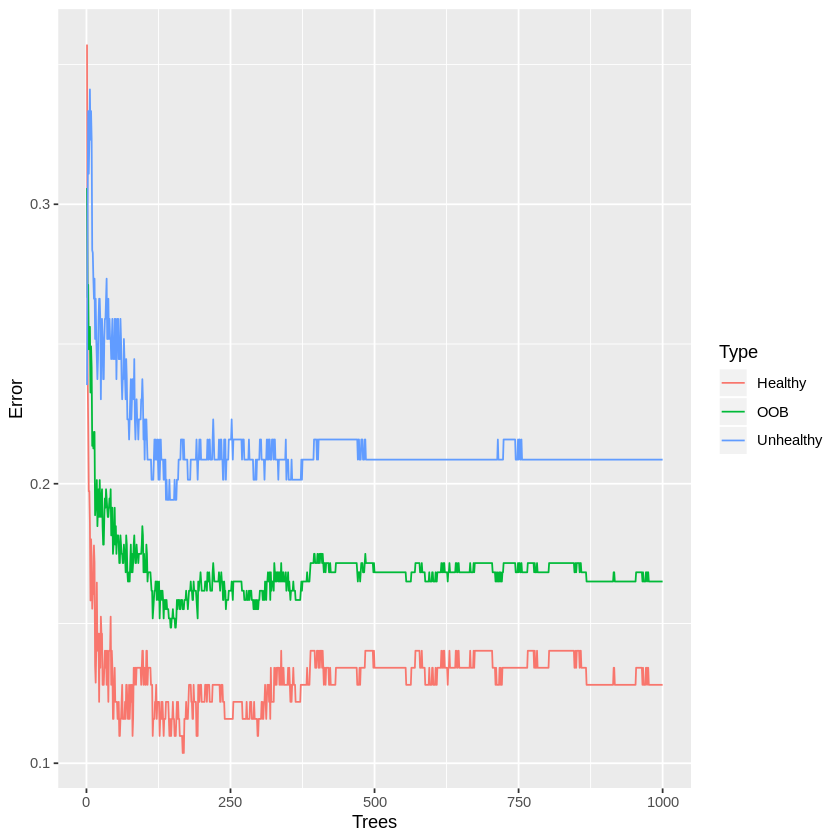

In [23]:
ggplot(data=oob.error.data, aes(x=Trees, y=Error)) +
  geom_line(aes(color=Type))
# ggsave("oob_error_rate_1000_trees.pdf")

> After building a random forest with 1,000 trees, we get the same OOB-error
> 16.5% and we can see convergence in the graph. So we could have gotten
> away with only 500 trees, but we wouldn't have been sure that number
> was enough.

### mtry

In [24]:
## If we want to compare this random forest to others with different values for
## mtry (to control how many variables are considered at each step)...
oob.values <- vector(length=10)
for(i in 1:10) {
  temp.model <- randomForest(hd ~ ., data=data.imputed, mtry=i, ntree=1000)
  oob.values[i] <- temp.model$err.rate[nrow(temp.model$err.rate),1]
}
oob.values
## [1] 0.1716172 0.1716172 0.1617162 0.1848185 0.1749175 0.1947195 0.1815182
## [8] 0.2013201 0.1881188 0.1947195
## The lowest value is when mtry=3, so the default setting was the best.

[1] 0.1716172 0.1683168 0.1683168 0.1782178 0.1815182 0.1749175 0.1848185
 [8] 0.1782178 0.1848185 0.1947195

## MDS

In [25]:
## Now let's create an MDS-plot to show how the samples are related to each
## other.
##
## Start by converting the proximity matrix into a distance matrix.
distance.matrix <- dist(1-model$proximity) 
mds.stuff <- cmdscale(distance.matrix, eig=TRUE, x.ret=TRUE)

In [26]:
## calculate the percentage of variation that each MDS axis accounts for...
mds.var.per <- round(mds.stuff$eig/sum(mds.stuff$eig)*100, 1)

In [27]:
## now make a fancy looking plot that shows the MDS axes and the variation:
mds.values <- mds.stuff$points
mds.data <- data.frame(Sample=rownames(mds.values),
  X=mds.values[,1],
  Y=mds.values[,2],
  Status=data.imputed$hd)

In [33]:
str(mds.data)

'data.frame':	303 obs. of  4 variables:
 $ Sample: Factor w/ 303 levels "1","10","100",..: 1 112 223 238 249 260 271 282 293 2 ...
 $ X     : num  -0.147 -1.221 -2.502 0.922 2.37 ...
 $ Y     : num  -0.9035 -0.0823 1.3299 -0.0472 1.0534 ...
 $ Status: Factor w/ 2 levels "Healthy","Unhealthy": 1 2 2 1 1 1 2 1 2 2 ...


In [35]:
str(data.imputed)

'data.frame':	303 obs. of  14 variables:
 $ hd      : Factor w/ 2 levels "Healthy","Unhealthy": 1 2 2 1 1 1 2 1 2 2 ...
 $ age     : num  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : Factor w/ 2 levels "F","M": 2 2 2 2 1 2 1 1 2 2 ...
 $ cp      : Factor w/ 4 levels "1","2","3","4": 1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: num  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : num  233 286 229 250 204 236 268 354 254 203 ...
 $ fbs     : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 2 ...
 $ restecg : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 1 3 1 3 3 ...
 $ thalach : num  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 2 ...
 $ oldpeak : num  2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ slope   : Factor w/ 3 levels "1","2","3": 3 2 2 3 1 1 3 1 2 3 ...
 $ ca      : Factor w/ 4 levels "2","3","4","5": 1 4 3 1 1 1 3 1 2 1 ...
 $ thal    : Factor w/ 3 levels "2","3","4": 2 1 3 1 1 1 1 1 3 3 ...


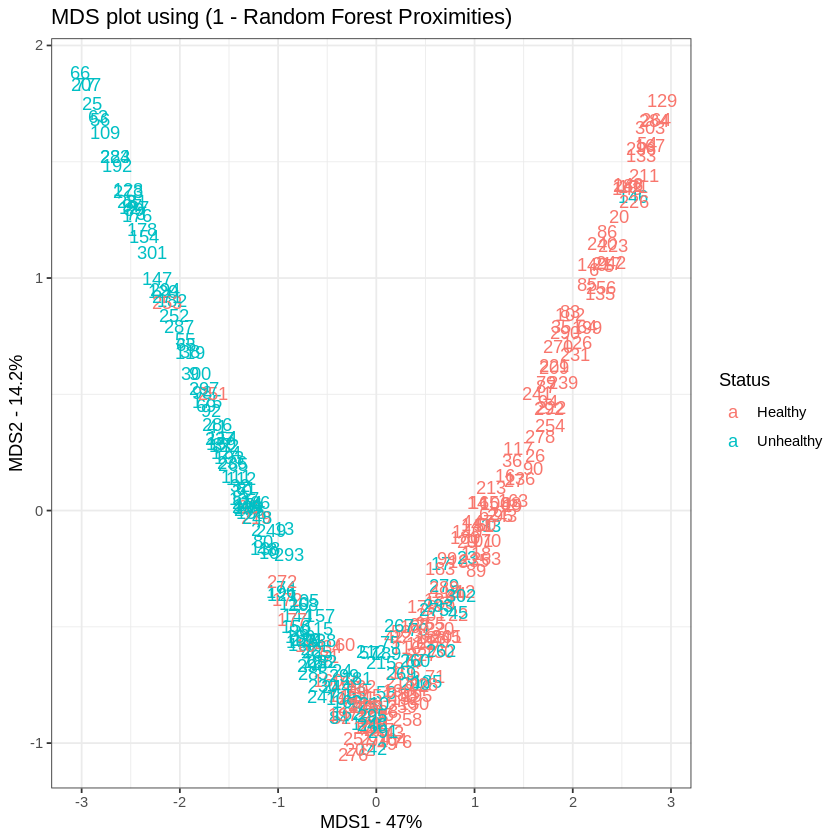

In [31]:
ggplot2::theme_set(cowplot::theme_cowplot())
ggplot(data=mds.data, aes(x=X, y=Y, label=Sample)) +
  geom_text(aes(color=Status)) +
  theme_bw() +
  xlab(paste("MDS1 - ", mds.var.per[1], "%", sep="")) +
  ylab(paste("MDS2 - ", mds.var.per[2], "%", sep="")) +
  ggtitle("MDS plot using (1 - Random Forest Proximities)")

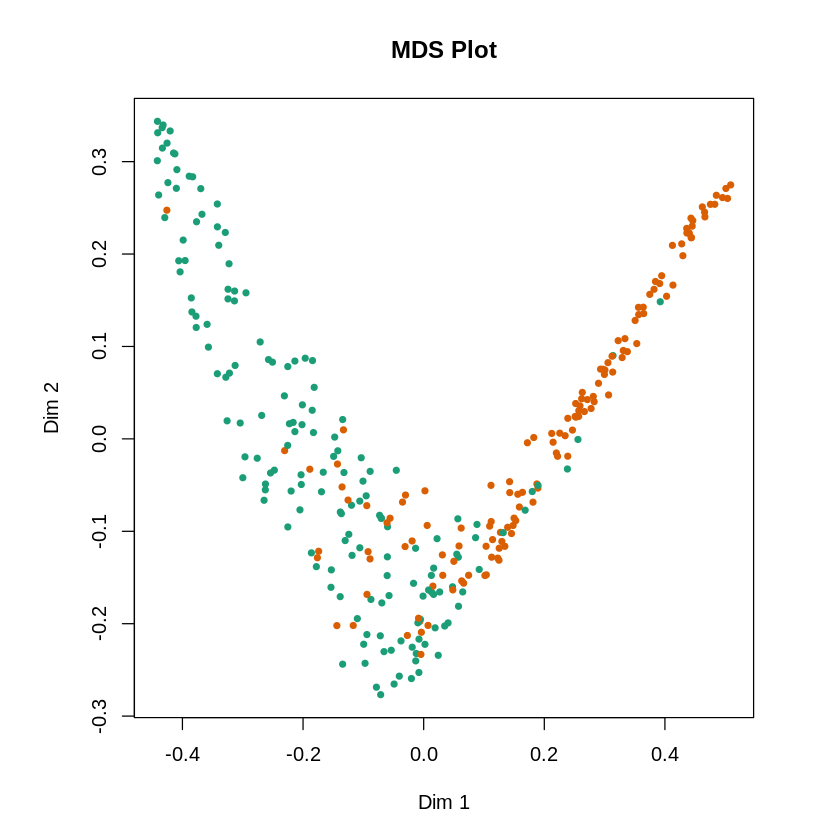

In [39]:
# https://www.datanovia.com/en/blog/top-r-color-palettes-to-know-for-great-data-visualization/#rcolorbrewer-palettes
randomForest::MDSplot(rf = model, 
                      fac = data.imputed$hd, 
                      k = 2, 
                      palette = RColorBrewer::brewer.pal(n = 3, name = 'Dark2'),
                      main = 'MDS Plot'
)